In [8]:
import sys
sys.path.insert(0, '/mnt/deliang-data/projects/CovidDepressionAnalysis/scripts/data_processing')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import pickle as pkl

from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from constants import *


from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imputation_data_structure import *


import shap
import xgboost
from xgboost import cv

%load_ext autoreload
%autoreload 2



/mnt/deliang-data/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [73]:
external_data = pd.read_csv('../data/css_panel_2020-2022.tab', sep='\t')

KeyboardInterrupt: 

In [74]:
external_baseline = pd.read_csv('../data/css_baseline_demo.tab', sep='\t')
cvd_cases = pd.read_csv('../data/biweekly-covid-cases-per-million-people.csv')
cvd_deaths =pd.read_csv('../data/biweekly-covid-deaths-per-million-people.csv')

In [40]:
UK_cases = cvd_cases.loc[cvd_cases['Entity']=='United Kingdom'].rename({'Biweekly cases per million people': 'cases_per_1m'}, axis=1)
UK_deaths = cvd_deaths.loc[cvd_deaths['Entity']=='United Kingdom'].rename({'Biweekly deaths per million people': 'deaths_per_1m'}, axis=1)

In [41]:
UK_deaths['pd_datetime'] = pd.to_datetime(UK_deaths['Day'])
UK_cases['pd_datetime'] = pd.to_datetime(UK_cases['Day'])

In [42]:
external_data['pd_datetime'] = pd.to_datetime(external_data['date'], errors='coerce')

In [43]:
baseline = pd.to_datetime('3/27/2020')
start = pd.to_datetime('4/10/2020')
end = pd.to_datetime('10/10/2020')

In [76]:
external_baseline.loc[:, ['pers1', 'pers2', 'pers3']]

,pers1,pers2,pers3
0,2,1,7
1,5,2,4
2,7,7,1
3,1,1,5
4,1,1,1
...,...,...,...
73217,7,6,3
73218,5,5,7
73219,7,6,3
73220,4,5,5


In [79]:
external_baseline.loc[:, ['pers1', 'pers2', 'pers3']]

,pers1,pers2,pers3
0,2,1,1
1,5,2,4
2,7,7,7
3,1,1,3
4,1,1,7
...,...,...,...
73217,7,6,5
73218,5,5,1
73219,7,6,5
73220,4,5,3


In [77]:
flip = {'pers1': 0,
        'pers2': 0,
        'pers3': 1,
        'pers4': 0,
        'pers5': 0,
        'pers6': 1,
        'pers7': 0,
        'pers8': 0,
        'pers9': 0,
        'pers10': 1,
        'pers11': 0,
        'pers12': 0,
        'pers13': 0,
        'pers14': 1,
        'pers15': 0}

keys = flip.keys()

In [78]:
for key in keys:
    if flip[key] == 1:
        external_baseline[key] = 8 - external_baseline[key]

In [68]:
external_baseline['Neuroticism'] = external_baseline.loc[:, UCL_personality['Neuroticism']].sum(axis=1)
external_baseline['Extraversion'] = external_baseline.loc[:, UCL_personality['Extraversion']].sum(axis=1)
external_baseline['Openness'] = external_baseline.loc[:, UCL_personality['Openness']].sum(axis=1)
external_baseline['Agreeableness'] = external_baseline.loc[:, UCL_personality['Agreeableness']].sum(axis=1)
external_baseline['Conscientiousness'] = external_baseline.loc[:, UCL_personality['Conscientiousness']].sum(axis=1)

In [23]:
subset = external_data.loc[(external_data['pd_datetime']<end),:].copy()

In [24]:
first_lockdown_time = [pd.to_datetime('3/23/2020'), pd.to_datetime('5/10/2020')]
second_lockdown_time = [pd.to_datetime('9/14/2020'), pd.to_datetime('11/24/2020')]

In [25]:
subset.loc[:, 'lockdown'] = ((subset['pd_datetime'] > first_lockdown_time[0]) & (subset['pd_datetime'] < first_lockdown_time[1])) | ((subset['pd_datetime'] > second_lockdown_time[0]) & (subset['pd_datetime'] < second_lockdown_time[1]))

In [26]:
subset['lockdown'] = subset['lockdown'].astype(int)

In [27]:
subset[['week', 'lockdown', 'pd_datetime']]

,week,lockdown,pd_datetime
0,1,1,2020-03-25
1,2,1,2020-04-01
2,3,1,2020-04-08
3,4,1,2020-04-16
4,5,1,2020-04-24
...,...,...,...
1205412,23,0,2020-08-28
1205419,7,1,2020-05-07
1205420,8,0,2020-05-15
1205421,10,0,2020-05-23


In [28]:
subset.groupby(['week', 'lockdown', 'pd_datetime']).count()

record_id  wave_name  wave  date  covid  \
week lockdown pd_datetime                                            
1    0        2020-03-21           4          4     4     4      4   
              2020-03-22           7          7     7     7      7   
              2020-03-23          41         41    41    41     41   
     1        2020-03-24          37         37    37    37     37   
              2020-03-25          24         24    24    24     24   
...                              ...        ...   ...   ...    ...   
9    0        2020-05-18        5243       5243  5243  5243   5243   
              2020-05-19        5503       5503  5503  5503   5503   
              2020-05-20        5836       5836  5836  5836   5836   
              2020-05-21        5327       5327  5327  5327   5327   
              2020-05-22        4767       4767  4767  4767   4767   

                           covidcontact  covidw  covidtest  covidwhen  \
week lockdown pd_datetime                                               
1    0        2020-03-21              4       4          4          4   
              2020-03-22              7       7          7          7   
              2020-03-23             41      41         41         41   
     1        2020-03-24             37      37         37         37   
              2020-03-25             24      24         24         24   
...                                 ...     ...        ...        ...   
9    0        2020-05-18           5243    5243       5243       5243   
              2020-05-19           5503    5503       5503       5503   
              2020-05-20           5836    5836       5836       5836   
              2020-05-21           5327    5327       5327       5327   
              2020-05-22           4767    4767       4767       4767   

                           covidwhen_2  ...  lifeevent3_2022  lifeevent4_2022  \
week lockdown pd_datetime               ...                                     
1    0        2020-03-21             4  ...                4                4   
              2020-03-22             7  ...                7                7   
              2020-03-23            41  ...               41               41   
     1        2020-03-24            37  ...               37               37   
              2020-03-25            24  ...               24               24   
...                                ...  ...              ...              ...   
9    0        2020-05-18          5243  ...             5243             5243   
              2020-05-19          5503  ...             5503             5503   
              2020-05-20          5836  ...             5836             5836   
              2020-05-21          5327  ...             5327             5327   
              2020-05-22          4767  ...             4767             4767   

                           lifeevent5_2022  lifeevent6_2022  lifeevent7_2022  \
week lockdown pd_datetime                                                      
1    0        2020-03-21                 4                4                4   
              2020-03-22                 7                7                7   
              2020-03-23                41               41               41   
     1        2020-03-24                37               37               37   
              2020-03-25                24               24               24   
...                                    ...              ...              ...   
9    0        2020-05-18              5243             5243             5243   
              2020-05-19              5503             5503             5503   
              2020-05-20              5836             5836             5836   
              2020-05-21              5327             5327             5327   
              2020-05-22              4767             4767             4767   

                           lifeevent8_2022  lifeevent9_2022  lifeevent1

In [29]:
len(subset['pd_datetime'].unique())

203

In [30]:
subset['depression'] = subset[UCL_depression].replace(' ', np.nan).astype(float).sum(axis=1)
subset['anxiety'] = subset[UCL_anxiety].replace(' ', np.nan).astype(float).sum(axis=1)
subset['covid_anxiety'] = subset[UCL_covid_anxiety].replace(' ', np.nan).astype(float).sum(axis=1)
subset['stress'] = subset[UCL_stressors].replace(' ', np.nan).astype(float).sum(axis=1)
subset['loneliness'] = subset[UCL_loneliness].replace(' ', np.nan).astype(float).sum(axis=1)
subset['support'] = subset[UCL_support].replace(' ', np.nan).astype(float).sum(axis=1)


In [31]:
subset['week'] = subset['week'].astype(int)

In [32]:
subset = subset.merge(UK_deaths[['pd_datetime', 'deaths_per_1m']], on='pd_datetime')
subset = subset.merge(UK_cases[['pd_datetime', 'cases_per_1m']], on='pd_datetime')

In [69]:
records = pd.merge(subset, external_baseline, on='record_id', how='left')

In [70]:
personality = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness']

columns = ['depression', 'anxiety', 'covid_anxiety', 'stress', 'loneliness', 'support', 'lockdown', 'week', 'record_id', 'cases_per_1m', 'deaths_per_1m'] + UCL_demographic + personality

selected_subset = records[columns]

In [71]:
selected_subset.head()

,depression,anxiety,covid_anxiety,stress,loneliness,support,lockdown,week,record_id,cases_per_1m,...,gender,ethnic,marital,education,income,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness
0,6.0,1.0,0.0,4.0,4.0,11.0,1,1,1,176.54,...,1,1,4,2,3,4,11,16,15,21
1,10.0,6.0,0.0,11.0,5.0,24.0,1,1,9,176.54,...,2,1,2,5,2,11,21,19,20,13
2,3.0,0.0,0.0,9.0,4.0,16.0,1,1,10,176.54,...,1,1,1,5,2,8,21,16,15,14
3,14.0,14.0,0.0,11.0,6.0,23.0,1,1,12,176.54,...,2,1,1,3,7,17,10,14,21,13
4,14.0,5.0,0.0,9.0,11.0,9.0,1,1,13,176.54,...,2,1,2,4,1,12,18,16,16,14


In [72]:
selected_subset.to_csv('../output/v3_python/UCL_data.csv')

<Axes: xlabel='week', ylabel='depression'>

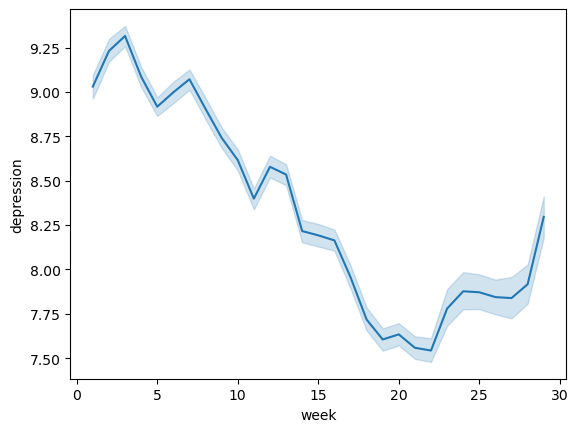

In [34]:
sns.lineplot(data=subset, x='week', y='depression')

<Axes: xlabel='week', ylabel='lockdown'>

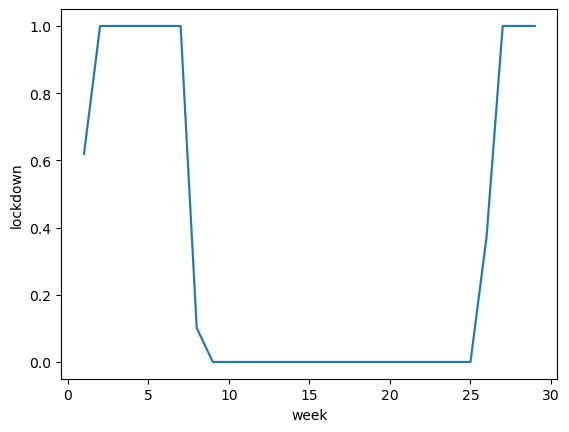

In [35]:
sns.lineplot(data=subset, x='week', y='lockdown')

In [37]:
subset

,record_id,wave_name,wave,date,week,covid,covidcontact,covidw,covidtest,covidwhen,...,lifeevent6_2022,lifeevent7_2022,lifeevent8_2022,lifeevent9_2022,lifeevent10_2022,lifeevent11_2022,lifeevent12_2022,pd_datetime,lockdown,depression
0,1,week_1,1,3/25/2020,1,4,2,,,,...,,,,,,,,2020-03-25,1,6.0
1,1,week_2,2,4/1/2020,2,4,3,,,,...,,,,,,,,2020-04-01,1,5.0
2,1,week_3,3,4/8/2020,3,4,1,,,,...,,,,,,,,2020-04-08,1,9.0
3,1,week_4,4,4/16/2020,4,4,1,,,,...,,,,,,,,2020-04-16,1,7.0
4,1,week_5,5,4/24/2020,5,4,1,,,,...,,,,,,,,2020-04-24,1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205412,80412,week_9,9,8/28/2020,23,4,1,,,,...,,,,,,,,2020-08-28,0,2.0
1205419,80413,week_1,1,5/7/2020,7,4,3,,,,...,,,,,,,,2020-05-07,1,21.0
1205420,80413,week_2,2,5/15/2020,8,4,1,,,,...,,,,,,,,2020-05-15,0,10.0
1205421,80413,week_3,3,5/23/2020,10,4,3,,,,...,,,,,,,,2020-05-23,0,14.0


In [36]:
n_weeks = len(subset['week'].unique())

In [27]:
ids = subset['record_id'].unique().tolist()

subset_ids = ids

selected_subjects = subset.loc[subset['record_id'].isin(subset_ids)]

In [28]:
ids = selected_subjects['record_id'].unique().tolist()

n_weeks = len(selected_subjects['week'].unique())

print('n participants before filtering:')
print(len(ids))

corrs = []
pvals = []
selected_ids = []

for i in ids:
    lockdown_measures = selected_subjects.loc[selected_subjects['record_id'] == i, 'lockdown'].values
    depression = selected_subjects.loc[selected_subjects['record_id'] == i, 'depression'].values
    
    if len(lockdown_measures) >= (0.5 * n_weeks):
        corr, pval = stats.pearsonr(lockdown_measures, depression)
        corrs.append(corr)
        pvals.append(pval)
        selected_ids.append(i)

df = pd.DataFrame({'id': selected_ids, 'corr': corrs, 'pval': pvals})

n participants before filtering:
71544


An input array is constant; the correlation coefficient is not defined.


In [29]:
subset_50 = subset.loc[subset['record_id'].isin(df['id'])]

In [30]:
subset_50['anxiety'] = subset_50.loc[:, UCL_anxiety].replace(' ', np.nan).astype(float).sum(axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
from imputation_data_structure import *

In [32]:
records = pd.merge(subset_50, external_baseline, on='record_id', how='left')

In [33]:
columns = ['depression', 'anxiety', 'lockdown'] + UCL_demographic

data_struct = Structure(records, columns, dtype='ucl-social-study')

In [34]:
data_struct.knn_impute_subject(k=2, reset=True)
data_struct.knn_impute_wave(k=5, reset=False)

In [36]:
data_struct.imputed.shape

(27335, 7, 29)

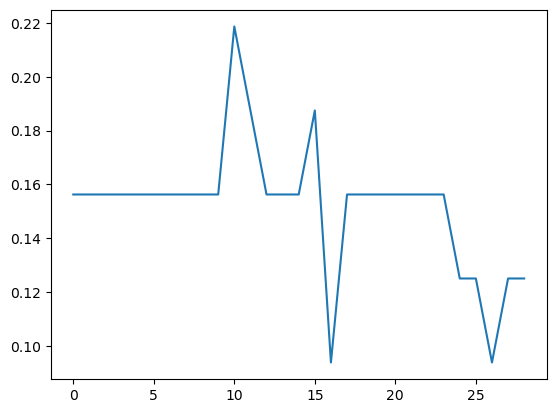

In [38]:
plt.plot(data_struct.imputed[0,0,:])

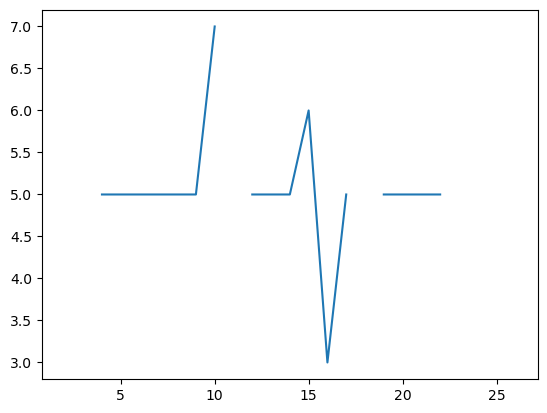

In [39]:
plt.plot(data_struct.ori[0,0,:])

In [14]:
import pickle

# Save the object as a pickle file
with open('../output/imputed.pkl', 'wb') as f:
    pickle.dump(data_struct, f)

NameError: name 'data_struct' is not defined

In [15]:
import pickle

# Open the pickle file and load the object
with open('../output/UCL/imputed.pkl', 'rb') as f:
    imputed_data = pickle.load(f)

In [24]:
imputed_data.reset_imputed()

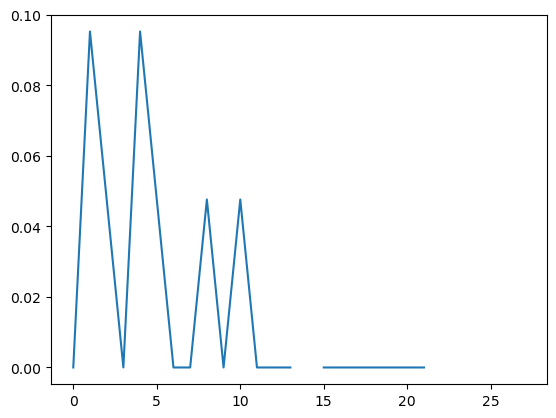

In [70]:
plt.plot(imputed_data.scaled_ori[100,1,:])

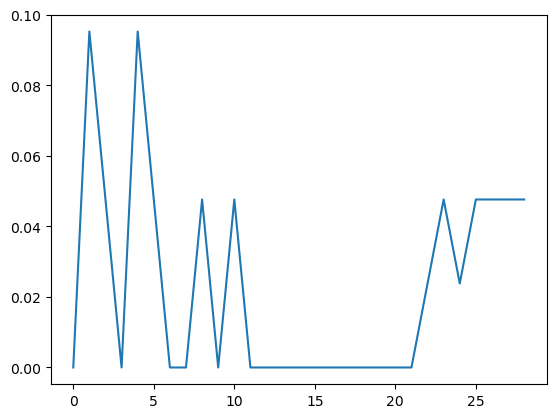

In [68]:
plt.plot(imputed_data.imputed[100,1,:])

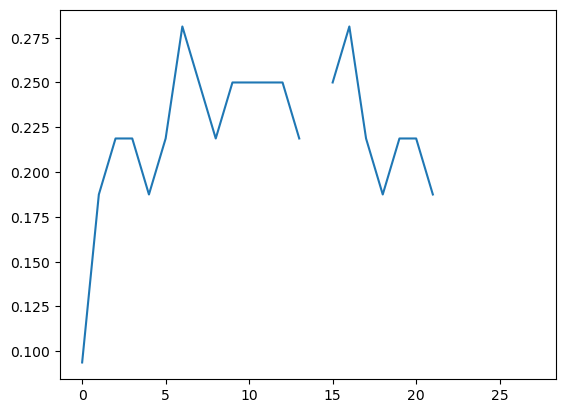

In [69]:
plt.plot(imputed_data.scaled_ori[100,0,:])

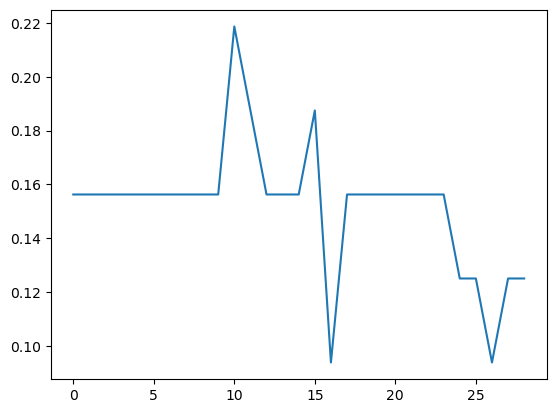

In [28]:
plt.plot(imputed_data.imputed[0,0,:])

In [29]:
imputed_data.ori.shape

(27335, 6, 29)

In [45]:
imputed_data.meta['columns']

['depression', 'anxiety', 'age', 'gender', 'marital', 'education']

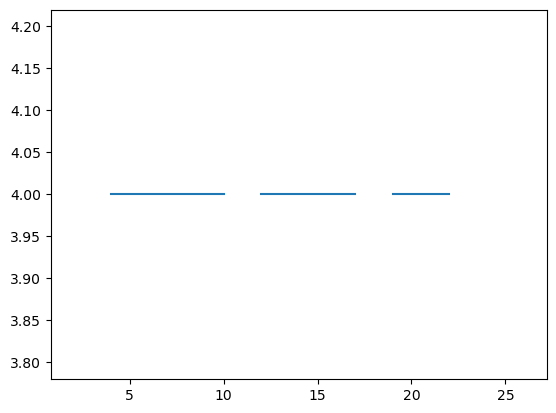

In [48]:
n = 5
plt.plot(imputed_data.ori[0,n,:])


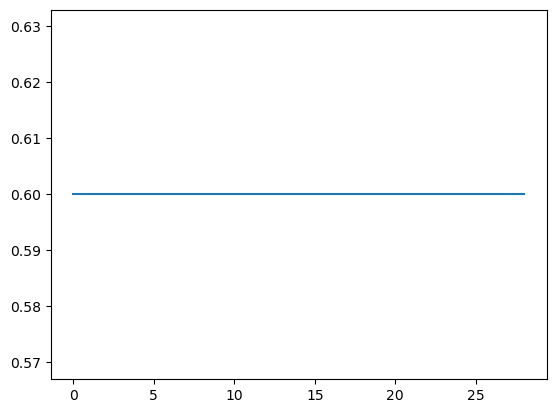

In [49]:
plt.plot(imputed_data.imputed[0,n,:])

In [42]:
imputed_data.knn_impute_subject(k=2, reset=False)
#imputed_data.knn_impute_wave(k=5, reset=False)

In [39]:
imputed_data

In [40]:
imputed_data.meta['waves']

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [41]:
imputed_data.imputed.shape

(27335, 6, 29)

In [42]:
imputed_data.meta['columns']

['depression', 'anxiety', 'age', 'gender', 'marital', 'education']

In [43]:
imputed_data.imputed[0, imputed_data.meta['columns'].index('depression'), :]

array([0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625, 0.15625,
       0.15625, 0.15625, 0.15625, 0.21875, 0.1875 , 0.15625, 0.15625,
       0.15625, 0.1875 , 0.09375, 0.15625, 0.15625, 0.15625, 0.15625,
       0.15625, 0.15625, 0.15625, 0.125  , 0.125  , 0.09375, 0.125  ,
       0.125  ])

In [46]:
imputed_data.reset_imputed()

In [47]:
target_vars = ['depression', 'anxiety']
n_samples = int(np.sum(~np.isnan(imputed_data.ori)) * (10/100))
test_indexes, _ = imputed_data.create_testing_data(n_samples=n_samples)
target_indexes = imputed_data.get_targeted_indexes(test_indexes, target_vars)

In [48]:
# Save the object as a pickle file
with open('../output/test_indexes.pkl', 'wb') as f:
    pickle.dump(test_indexes, f)

In [65]:
imputed_data.imputed[test_indexes[0]]




0.5

In [66]:
imputed_data.set_na_values(test_indexes)

In [67]:
imputed_data.imputed[test_indexes[0]]


nan

In [68]:
imputed_data.knn_impute_subject(k=2, reset=False)
imputed_data.knn_impute_wave(k=5, reset=False)

In [71]:
n = test_indexes[200]
print(imputed_data.imputed[n])
print(imputed_data.scaled_ori[n])


0.359375
0.28125


In [ ]:
imputed_data.set_na_values(test_indexes)

In [72]:

mse, valid_testcase = imputed_data.estimate_imputation_error(test_indexes)
target_mse, target_valid_test = imputed_data.estimate_imputation_error(target_indexes)



In [73]:
target_mse

0.006792081818524861

In [ ]:
ids = imputed_data.meta['CVDIDs']
n_weeks = len(imputed_data.meta['waves'])

print('n participants before filtering:')
print(len(ids))

corrs = []
pvals = []
selected_ids = []

for i in ids:
    lockdown_measures = selected_subjects.loc[selected_subjects['record_id'] == i, 'lockdown'].values
    depression = imputed_data.imputed[0, imputed_data.meta['columns'].index('depression'), :]
    
    if len(lockdown_measures) >= (0.5 * n_weeks):
        corr, pval = stats.pearsonr(lockdown_measures, depression)
        corrs.append(corr)
        pvals.append(pval)
        selected_ids.append(i)

df = pd.DataFrame({'id': selected_ids, 'corr': corrs, 'pval': pvals})

In [29]:
negative_participants = non_na_df.loc[(non_na_df['corr'] < 0) & (non_na_df['pval'] <= 0.05)]
positive_participants = non_na_df.loc[(non_na_df['corr'] > 0) & (non_na_df['pval'] <= 0.05)]
neutral_participants = non_na_df.loc[non_na_df['pval'] > 0.05]

In [30]:
neutral_participants

,id,corr,pval
0,4,-0.251476,0.299012
1,5,0.205370,0.359211
2,10,0.137568,0.552075
3,12,-0.092857,0.722991
4,13,0.136957,0.553859
...,...,...,...
27330,80380,0.085480,0.744278
27331,80381,-0.091287,0.727505
27332,80384,-0.310557,0.259921
27333,80387,0.106920,0.682952


In [31]:
positive_participants

,id,corr,pval
6,23,0.446344,0.042536
22,71,0.516568,0.016504
24,74,0.622682,0.007590
25,84,0.451661,0.030504
26,89,0.514173,0.017100
...,...,...,...
27177,79514,0.696366,0.001900
27181,79537,0.683130,0.003535
27289,80173,0.775150,0.000687
27309,80279,0.581666,0.018101


In [32]:
negative_ids = negative_participants['id'].tolist()
positive_ids = positive_participants['id'].tolist()
neutral_ids = positive_participants['id'].tolist()

In [33]:
positive_dep_extraversion = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Extraversion'].tolist()
negative_dep_extraversion = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Extraversion'].tolist()

In [34]:
positive_dep_neuroticism = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Neuroticism'].tolist()
negative_dep_neuroticism = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Neuroticism'].tolist()

positive_dep_agreeableness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Agreeableness'].tolist()
negative_dep_agreeableness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Agreeableness'].tolist()

positive_dep_openness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Openness'].tolist()
negative_dep_openness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Openness'].tolist()

positive_dep_conscientiousness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Conscientiousness'].tolist()
negative_dep_conscientiousness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Conscientiousness'].tolist()

In [35]:
stats.ttest_ind(positive_dep_extraversion, negative_dep_extraversion)

Ttest_indResult(statistic=-1.4706405919384042, pvalue=0.1414449890600788)

In [ ]:
stats.ttest_ind(positive_dep_neuroticism, negative_dep_neuroticism)

Ttest_indResult(statistic=-4.479048187277701, pvalue=7.647930215678944e-06)

In [ ]:
stats.ttest_ind(positive_dep_agreeableness, negative_dep_agreeableness)

Ttest_indResult(statistic=-3.386710945148541, pvalue=0.000712270071374352)

In [ ]:
stats.ttest_ind(positive_dep_openness, negative_dep_openness)

Ttest_indResult(statistic=1.0519030713300306, pvalue=0.29288978601047566)

In [ ]:
stats.ttest_ind(positive_dep_conscientiousness, negative_dep_conscientiousness)

Ttest_indResult(statistic=-1.032417629340353, pvalue=0.30192147010943715)

In [ ]:
records = pd.merge(non_na_df, external_baseline, left_on='id', right_on='record_id', how='left')

In [ ]:
records['cls'] = 'positive'
records.loc[(records['corr']<0) & (records['pval']<=0.05), 'cls'] = 'negative'
records.loc[~(((records['corr']>0) & (records['pval']<=0.05)) | ((records['corr']<0) & (records['pval']<=0.05))), 'cls'] = 'neutral'

In [ ]:
records.columns.tolist()

['id',
 'corr',
 'pval',
 'record_id',
 'age',
 'gender',
 'ethnic',
 'marital',
 'education',
 'employment',
 'keyworker1',
 'keyworker2',
 'keyworker3',
 'keyworker4',
 'keyworker5',
 'keyworker6',
 'keyworker7',
 'keyworker8',
 'keyworker9',
 'keyworker10',
 'country',
 'area',
 'region',
 'living',
 'ownership',
 'garden1',
 'garden2',
 'garden3',
 'garden4',
 'rooms',
 'houseadults',
 'housechildren',
 'income',
 'illness1',
 'illness2',
 'illness3',
 'illness4',
 'illness5',
 'illness6',
 'illness7',
 'illness8',
 'illness9',
 'illness12',
 'illness13',
 'illness10',
 'illness11',
 'smoker',
 'alcohol',
 'exercise',
 'caring1',
 'caring2',
 'caring3',
 'pets1',
 'pets2',
 'pets3',
 'pets4',
 'pets5',
 'closefriends',
 'socfreq',
 'pers1',
 'pers2',
 'pers3',
 'pers4',
 'pers5',
 'pers6',
 'pers7',
 'pers8',
 'pers9',
 'pers10',
 'pers11',
 'pers12',
 'pers13',
 'pers14',
 'pers15',
 'w1wgt',
 'Neuroticism',
 'Extraversion',
 'Openness',
 'Agreeableness',
 'Conscientiousness',
 'c

In [ ]:
selected_vars = [   'age',
                    'gender',
                    'ethnic',
                    'marital',
                    'education',
                    'employment',
                    'Neuroticism',
                    'Extraversion',
                    'Openness',
                    'Agreeableness',
                    'Conscientiousness',
                    'cls']

subset = records[selected_vars]

X = subset.drop(['cls'], axis=1)
y = subset['cls'].values == 'negative'

d_X = xgboost.DMatrix(X, label=y)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "auc"
}

# Perform cross-validation
num_rounds = 10000
num_folds = 5

cv_results = cv(
    params,
    d_X,
    num_boost_round=num_rounds,
    nfold=num_folds,
    early_stopping_rounds=200,
    metrics='auc',
    seed=42,
    verbose_eval=True
)

# Print the cross-validation results
print(cv_results)

[0]	train-auc:0.60257+0.00370	test-auc:0.54846+0.00855
[1]	train-auc:0.62760+0.00464	test-auc:0.55427+0.00459
[2]	train-auc:0.64265+0.00399	test-auc:0.56179+0.00368
[3]	train-auc:0.64995+0.00250	test-auc:0.56621+0.00444
[4]	train-auc:0.65403+0.00306	test-auc:0.57103+0.00664
[5]	train-auc:0.65955+0.00425	test-auc:0.57174+0.00643
[6]	train-auc:0.66442+0.00504	test-auc:0.56912+0.00688
[7]	train-auc:0.66687+0.00627	test-auc:0.57023+0.00622
[8]	train-auc:0.67000+0.00642	test-auc:0.57250+0.00731
[9]	train-auc:0.67147+0.00645	test-auc:0.57340+0.00862
[10]	train-auc:0.67266+0.00614	test-auc:0.57375+0.00934
[11]	train-auc:0.67364+0.00660	test-auc:0.57398+0.01033
[12]	train-auc:0.67559+0.00601	test-auc:0.57428+0.01032
[13]	train-auc:0.67633+0.00581	test-auc:0.57509+0.01000
[14]	train-auc:0.67803+0.00585	test-auc:0.57564+0.00987
[15]	train-auc:0.67822+0.00444	test-auc:0.57575+0.00927
[16]	train-auc:0.67929+0.00468	test-auc:0.57737+0.01025
[17]	train-auc:0.68050+0.00419	test-auc:0.57791+0.00980
[1

[0]	test-auc:0.53718
[100]	test-auc:0.57395
[200]	test-auc:0.56545
[295]	test-auc:0.56724


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


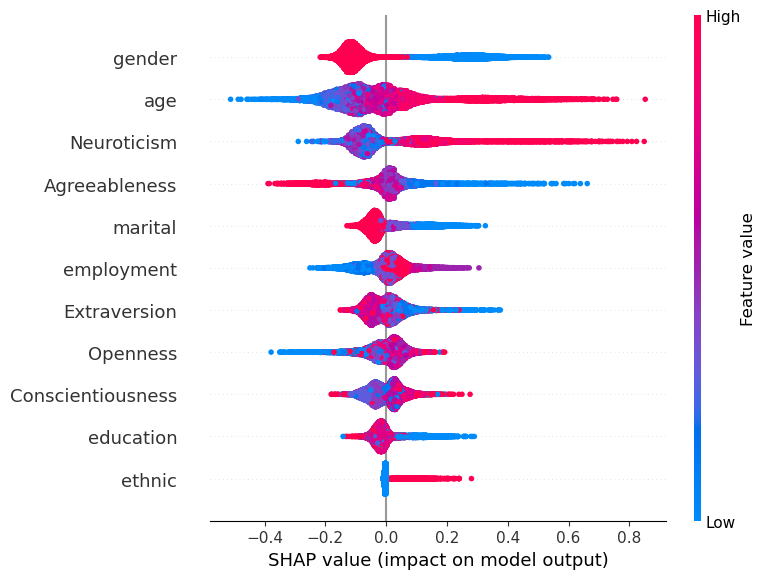

In [135]:
X = subset.drop(['cls'], axis=1)
y = subset['cls'].values == 'negative'


# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgboost.train(params, d_train, 10000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=200)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [71]:
subset.loc[subset['record_id']==3]

,record_id,wave_name,wave,date,week,covid,covidcontact,covidw,covidtest,covidwhen,...,lifeevent6_2022,lifeevent7_2022,lifeevent8_2022,lifeevent9_2022,lifeevent10_2022,lifeevent11_2022,lifeevent12_2022,pd_datetime,lockdown,depression
7,3,week_1,1,4/23/2020,5,4,1,,,,...,,,,,,,,2020-04-23,True,22.0
8,3,week_2,2,4/30/2020,6,4,3,,,,...,,,,,,,,2020-04-30,True,20.0
9,3,week_3,3,5/8/2020,7,4,3,,,,...,,,,,,,,2020-05-08,True,20.0
10,3,week_4,4,5/19/2020,9,4,3,,,,...,,,,,,,,2020-05-19,False,15.0
11,3,week_5,5,5/26/2020,10,4,1,,,,...,,,,,,,,2020-05-26,False,10.0
